# 数据读取与预处理

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
)
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']  # Windows系统优先微軟雅黑
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
data = np.genfromtxt('./data/LeukemiaDataSet3.dat', delimiter='  ', dtype=str)

# 修正：先将第一列转换为浮点数，再转换为整数
X = data[:, 1:].astype(float)
y = data[:, 0].astype(float).astype(int)  # 先转浮点再转整数

# 检查数据基本信息
print(f"样本数: {X.shape[0]}, 特征数: {X.shape[1]}")
print(f"类别分布: {np.unique(y, return_counts=True)}")

# 改进的标准化和划分
# 先划分再分别标准化，避免数据泄露
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=21, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # 只用训练集的参数

print(f"训练集: {X_train_scaled.shape}, 测试集: {X_test_scaled.shape}")

样本数: 72, 特征数: 7129
类别分布: (array([0, 1, 2]), array([38,  9, 25], dtype=int64))
训练集: (50, 7129), 测试集: (22, 7129)


# 实验

Decision Tree        测试集准确率: 0.7727
Naive Bayes          测试集准确率: 0.9545
KNN                  测试集准确率: 0.7273
SVM                  测试集准确率: 0.7273
Random Forest        测试集准确率: 0.8636
AdaBoost             测试集准确率: 0.8182
Gradient Boosting    测试集准确率: 0.9091
XGBoost              测试集准确率: 0.9545


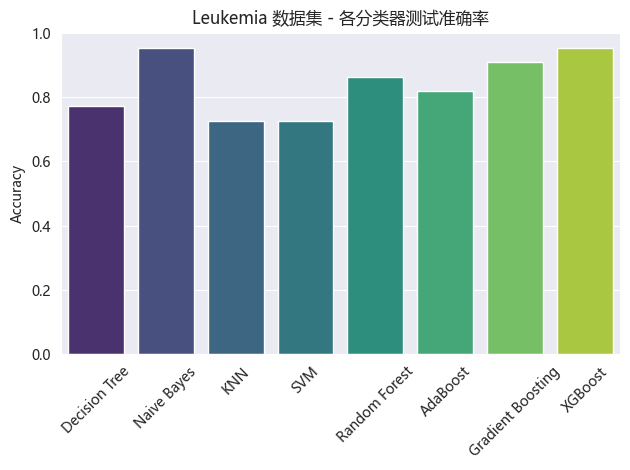

In [17]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=21),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=21),
    "Random Forest": RandomForestClassifier(random_state=21),
    "AdaBoost": AdaBoostClassifier(random_state=21),
    "Gradient Boosting": GradientBoostingClassifier(random_state=21),
    "XGBoost": xgb.XGBClassifier(random_state=21)
}

single_classify_results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    single_classify_results[name] = acc
    print(f"{name:20} 测试集准确率: {acc:.4f}")

# 可视化
sns.barplot(
    x=list(single_classify_results.keys()),
    y=list(single_classify_results.values()),
    hue=list(single_classify_results.keys()),
    dodge=False,
    palette="viridis",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Leukemia 数据集 - 各分类器测试准确率")
plt.tight_layout()
plt.show()

Hard Voting 准确率: 0.8636
Soft Voting 准确率: 0.9545
Decision Tree        CV均值 = 0.8200 ± 0.0748
Naive Bayes          CV均值 = 0.9400 ± 0.0800
KNN                  CV均值 = 0.7000 ± 0.1414
SVM                  CV均值 = 0.7200 ± 0.1166
Random Forest        CV均值 = 0.9200 ± 0.1166
AdaBoost             CV均值 = 0.8800 ± 0.0748
Gradient Boosting    CV均值 = 0.9600 ± 0.0800
XGBoost              CV均值 = 0.8400 ± 0.0800
加权 Soft Voting 准确率: 0.9545


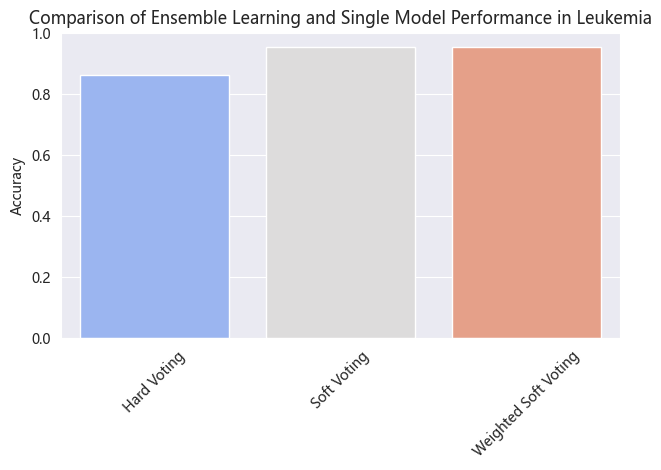

最佳模型: Soft Voting, 准确率 = 0.9545


In [24]:
# 组合1，所有的分类器
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=21),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=21),
    "Random Forest": RandomForestClassifier(random_state=21),
    "AdaBoost": AdaBoostClassifier(random_state=21),
    "Gradient Boosting": GradientBoostingClassifier(random_state=21),
    "XGBoost": xgb.XGBClassifier(random_state=21)
}
voting_hard = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='hard'
)
voting_hard.fit(X_train_scaled, y_train)
y_pred = voting_hard.predict(X_test_scaled)
hard_acc = accuracy_score(y_test, y_pred)
print(f"Hard Voting 准确率: {hard_acc:.4f}")

voting_soft = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft'
)
voting_soft.fit(X_train_scaled, y_train)
y_pred = voting_soft.predict(X_test_scaled)
soft_acc = accuracy_score(y_test, y_pred)
print(f"Soft Voting 准确率: {soft_acc:.4f}")

weights = {}
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    weights[name] = cv_scores.mean()
    print(f"{name:20} CV均值 = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

voting_weighted = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft',
    weights=[weights[n] for n in classifiers.keys()]
)
voting_weighted.fit(X_train_scaled, y_train)
y_pred = voting_weighted.predict(X_test_scaled)
weighted_acc = accuracy_score(y_test, y_pred)
print(f"加权 Soft Voting 准确率: {weighted_acc:.4f}")

voting_classify_results_1 = {}
voting_classify_results_1["Hard Voting"] = hard_acc
voting_classify_results_1["Soft Voting"] = soft_acc
voting_classify_results_1["Weighted Soft Voting"] = weighted_acc

sns.barplot(
    x=list(voting_classify_results_1.keys()),
    y=list(voting_classify_results_1.values()),
    hue=list(voting_classify_results_1.keys()),
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparison of Ensemble Learning and Single Model Performance in Leukemia")
plt.tight_layout()
plt.show()

best_model = max(voting_classify_results_1, key=voting_classify_results_1.get)
print(f"最佳模型: {best_model}, 准确率 = {voting_classify_results_1[best_model]:.4f}")

Hard Voting 准确率: 0.9545
Soft Voting 准确率: 0.9545
Naive Bayes          CV均值 = 0.9400 ± 0.0800
Gradient Boosting    CV均值 = 0.9600 ± 0.0800
XGBoost              CV均值 = 0.8400 ± 0.0800
加权 Soft Voting 准确率: 0.9545


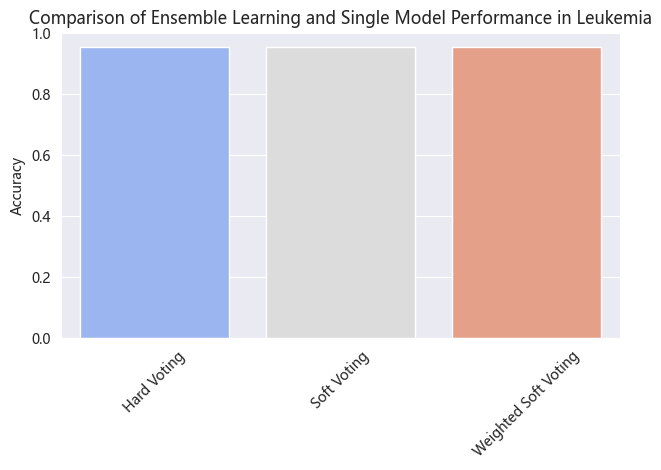

最佳模型: Hard Voting, 准确率 = 0.9545


In [25]:
# 组合2，最佳3分类器
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=21),
    "XGBoost": xgb.XGBClassifier(random_state=21)
}
voting_hard = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='hard'
)
voting_hard.fit(X_train_scaled, y_train)
y_pred = voting_hard.predict(X_test_scaled)
hard_acc = accuracy_score(y_test, y_pred)
print(f"Hard Voting 准确率: {hard_acc:.4f}")

voting_soft = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft'
)
voting_soft.fit(X_train_scaled, y_train)
y_pred = voting_soft.predict(X_test_scaled)
soft_acc = accuracy_score(y_test, y_pred)
print(f"Soft Voting 准确率: {soft_acc:.4f}")

weights = {}
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    weights[name] = cv_scores.mean()
    print(f"{name:20} CV均值 = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

voting_weighted = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft',
    weights=[weights[n] for n in classifiers.keys()]
)
voting_weighted.fit(X_train_scaled, y_train)
y_pred = voting_weighted.predict(X_test_scaled)
weighted_acc = accuracy_score(y_test, y_pred)
print(f"加权 Soft Voting 准确率: {weighted_acc:.4f}")

voting_classify_results_2 = {}
voting_classify_results_2["Hard Voting"] = hard_acc
voting_classify_results_2["Soft Voting"] = soft_acc
voting_classify_results_2["Weighted Soft Voting"] = weighted_acc

sns.barplot(
    x=list(voting_classify_results_2.keys()),
    y=list(voting_classify_results_2.values()),
    hue=list(voting_classify_results_2.keys()),
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparison of Ensemble Learning and Single Model Performance in Leukemia")
plt.tight_layout()
plt.show()

best_model = max(voting_classify_results_2, key=voting_classify_results_2.get)
print(f"最佳模型: {best_model}, 准确率 = {voting_classify_results_2[best_model]:.4f}")

Hard Voting 准确率: 0.9545
Soft Voting 准确率: 0.9545
Naive Bayes          CV均值 = 0.9400 ± 0.0800
Random Forest        CV均值 = 0.9200 ± 0.1166
Gradient Boosting    CV均值 = 0.9600 ± 0.0800
加权 Soft Voting 准确率: 0.9545


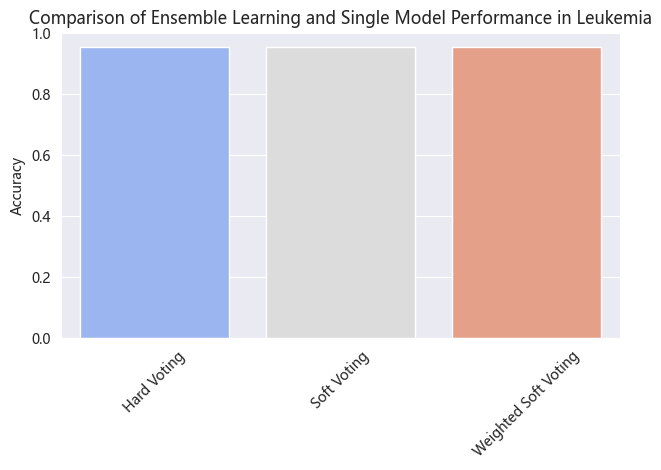

最佳模型: Hard Voting, 准确率 = 0.9545


In [26]:
# 组合3，集成中表现较好的三种
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=21),
    "Gradient Boosting": GradientBoostingClassifier(random_state=21),
}
voting_hard = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='hard'
)
voting_hard.fit(X_train_scaled, y_train)
y_pred = voting_hard.predict(X_test_scaled)
hard_acc = accuracy_score(y_test, y_pred)
print(f"Hard Voting 准确率: {hard_acc:.4f}")

voting_soft = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft'
)
voting_soft.fit(X_train_scaled, y_train)
y_pred = voting_soft.predict(X_test_scaled)
soft_acc = accuracy_score(y_test, y_pred)
print(f"Soft Voting 准确率: {soft_acc:.4f}")

weights = {}
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    weights[name] = cv_scores.mean()
    print(f"{name:20} CV均值 = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

voting_weighted = VotingClassifier(
    estimators=[(n, c) for n, c in classifiers.items()],
    voting='soft',
    weights=[weights[n] for n in classifiers.keys()]
)
voting_weighted.fit(X_train_scaled, y_train)
y_pred = voting_weighted.predict(X_test_scaled)
weighted_acc = accuracy_score(y_test, y_pred)
print(f"加权 Soft Voting 准确率: {weighted_acc:.4f}")

voting_classify_results_3 = {}
voting_classify_results_3["Hard Voting"] = hard_acc
voting_classify_results_3["Soft Voting"] = soft_acc
voting_classify_results_3["Weighted Soft Voting"] = weighted_acc

sns.barplot(
    x=list(voting_classify_results_3.keys()),
    y=list(voting_classify_results_3.values()),
    hue=list(voting_classify_results_3.keys()),
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparison of Ensemble Learning and Single Model Performance in Leukemia")
plt.tight_layout()
plt.show()

best_model = max(voting_classify_results_3, key=voting_classify_results_3.get)
print(f"最佳模型: {best_model}, 准确率 = {voting_classify_results_3[best_model]:.4f}")